In [8]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


Compare algorithms provided on the others notebook all together.

MarchingSquareCythonArray
=========================

In [9]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonArray(object):

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points
    cdef cnumpy.uint8_t[:, :] _indexes

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        if mask is not None:
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            assert(image.shape == mask.shape)
        else:
            self._mask = None
        with nogil:
            wh = self._image.shape[0] + self._image.shape[1]
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            bint do_mask = self._mask is not None
            int dim_y = self._image.shape[0]
            int dim_x = self._image.shape[1]
            int x, y, i_segment, i_side, i_edge, index, indexes_count = 0
            double tmpf
        self._indexes = numpy.zeros((dim_y - 1, dim_x - 1), dtype=numpy.uint8)
        with nogil:
            for y in range(dim_y - 1):
                for x in range(dim_x - 1):

                    # Calculate index.
                    index = 0
                    if self._image[y, x] > isovalue:
                        index += 1
                    if self._image[y, x + 1] > isovalue:
                        index += 2
                    if self._image[y + 1, x + 1] > isovalue:
                        index += 4
                    if self._image[y + 1, x] > isovalue:
                        index += 8

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (self._image[y, x] +
                                       self._image[y, x + 1] +
                                       self._image[y + 1, x] +
                                       self._image[y + 1, x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if do_mask:
                        if self._mask[y, x] > 0:
                            index += 16
                        if self._mask[y, x + 1] > 0:
                            index += 32
                        if self._mask[y + 1, x + 1] > 0:
                            index += 64
                        if self._mask[y + 1, x] > 0:
                            index += 128

                    if index < 16 and index != 0 and index != 15:
                        self._indexes[y, x] = index
        return self._indexes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_point(self,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result):
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image[y + dy1, x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image[y + dy2, x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_next_segment(self,
                       cnumpy.int_t x, cnumpy.int_t y,
                       cnumpy.uint8_t index,
                       cnumpy.uint8_t edge,
                       next_segment_t *result):
        cdef:
            int next_x, next_y, next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                self._indexes[y, x] = 7
            else:
                # it's the second segment
                index = 8
                self._indexes[y, x] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                self._indexes[y, x] = 4
            else:
                # it's the second segment
                index = 4
                self._indexes[y, x] = 1
        else:
            self._indexes[y, x] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            assert False, "Unexpected behaviour"
        if next_x >= self._indexes.shape[1] or next_y >= self._indexes.shape[0] or next_x < 0 or next_y < 0:
            # out of the indexes
            result.x = -1
            return

        next_index = self._indexes[next_y, next_x]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        x, y, index, edge = next_x, next_y, next_index, next_edge

        result.x = x
        result.y = y
        result.index = index
        result.edge = edge
        return

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, int x, int y):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        ifrom = 2048
        ito = 2048
        index = self._indexes[y, x]
        index = index & 0x0F

        self._forward_points.clear()
        self._backward_points.clear()
        
        edge = CELL_TO_EDGE[index][1 + 0]
        first_pos.x = x
        first_pos.y = y
        first_pos.index = index
        first_pos.edge = edge
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            x, y, index, edge = next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

        x, y, index, edge = first_pos.x, first_pos.y, first_pos.index, first_pos.edge
        while True:
            self._compute_next_segment(x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            x, y, index, edge = next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._backward_points.push_back(point[1])
            self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y
            cnumpy.uint8_t index
        polygons = []
        with nogil:
            for y in range(self._indexes.shape[0]):
                for x in range(self._indexes.shape[1]):
                    index = self._indexes[y, x]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        continue
                    with gil:
                        polygon = self._extract_polygon(isovalue, x, y)
                        polygons.append(polygon)

                    if index == 5 or index == 10:
                        index = self._indexes[y, x]
                        index = index & 0x0F
                        if index == 0 or index == 15:
                            continue
                        # There is maybe a second polygon to extract
                        with gil:
                            polygon = self._extract_polygon(isovalue, x, y)
                            polygons.append(polygon)

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        return polygons

MarchingSquareCythonArrayOpt
============================

In [10]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int yx
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonArrayOpt(object):
    """Iso contour implementation using Cython with a 2d-array for the indexes.

    TODO: remove _backward_points
    TODO: use C array for _indexes
    TODO: concept of x,y could be removed for a single yx-index
    """
    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef cnumpy.uint8_t *_index_ptr
    cdef int _dim_x
    cdef int _dim_y

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points
    cdef cnumpy.uint8_t[:, :] _indexes

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]
            wh = self._dim_y + self._dim_x
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            int i
            int x, y, i_segment, i_side, i_edge, indexes_count = 0
            cnumpy.uint8_t index
            cnumpy.uint8_t *_index_ptr
            double tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr

        # allow dim_y/_x instead of dim_y-1/_x-1 to have everything aligned in memory
        self._indexes = numpy.zeros((self._dim_y, self._dim_x), dtype=numpy.uint8)
        with nogil:
            self._index_ptr = &self._indexes[0][0]
            _index_ptr = self._index_ptr
            _image_ptr = self._image_ptr
            _mask_ptr = self._mask_ptr
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    # Calculate index.
                    index = 0
                    if _image_ptr[0] > isovalue:
                        index += 1
                    if _image_ptr[1] > isovalue:
                        index += 2
                    if _image_ptr[self._dim_x] > isovalue:
                        index += 8
                    if _image_ptr[self._dim_x + 1] > isovalue:
                        index += 4

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (_image_ptr[0] +
                                       _image_ptr[1] +
                                       _image_ptr[self._dim_x] +
                                       _image_ptr[self._dim_x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if _mask_ptr != NULL:
                        _mask_ptr += 1
                        if _mask_ptr[0] > 0:
                            index += 16
                        if _mask_ptr[1] > 0:
                            index += 32
                        if _mask_ptr[self._dim_x] > 0:
                            index += 128
                        if _mask_ptr[self._dim_x + 1] > 0:
                            index += 64

                    if index < 16 and index != 0 and index != 15:
                        _index_ptr[0] = index

                    _index_ptr += 1
                    _image_ptr += 1

                # There is a missing pixel at the end of each rows
                _index_ptr += 1
                _image_ptr += 1
                if _mask_ptr != NULL:
                    _mask_ptr += 1

        return self._indexes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_point(self,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result):
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy1) * self._dim_x + x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy2) * self._dim_x + x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_next_segment(self,
                       cnumpy.int_t yx,
                       cnumpy.int_t x, cnumpy.int_t y,
                       cnumpy.uint8_t index,
                       cnumpy.uint8_t edge,
                       next_segment_t *result):
        cdef:
            int next_x, next_y, next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                self._index_ptr[yx] = 7
            else:
                # it's the second segment
                index = 8
                self._index_ptr[yx] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                self._index_ptr[yx] = 4
            else:
                # it's the second segment
                index = 4
                self._index_ptr[yx] = 1
        else:
            self._index_ptr[yx] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            assert False, "Unexpected behaviour"
        if next_x >= self._dim_x - 1 or next_y >= self._dim_y - 1 or next_x < 0 or next_y < 0:
            # out of the indexes
            result.x = -1
            return

        next_yx = next_y * self._dim_x + next_x
        next_index = self._index_ptr[next_yx]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        result.x = next_x
        result.y = next_y
        result.yx = next_yx
        result.index = next_index
        result.edge = next_edge
        return

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, int yx, int x, int y):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        ifrom = 2048
        ito = 2048
        index = self._index_ptr[yx]
        index = index & 0x0F

        self._forward_points.clear()
        self._backward_points.clear()
        
        edge = CELL_TO_EDGE[index][1 + 0]
        first_pos.yx = yx
        first_pos.x = x
        first_pos.y = y
        first_pos.index = index
        first_pos.edge = edge
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(yx, x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

        yx, x, y, index, edge = first_pos.yx, first_pos.x, first_pos.y, first_pos.index, first_pos.edge
        while True:
            self._compute_next_segment(yx, x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._backward_points.push_back(point[1])
            self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y, yx
            cnumpy.uint8_t index
        polygons = []
        with nogil:
            yx = 0
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    index = self._index_ptr[yx]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        yx += 1
                        continue
                    with gil:
                        polygon = self._extract_polygon(isovalue, yx, x, y)
                        polygons.append(polygon)

                    if index == 5 or index == 10:
                        index = self._index_ptr[yx]
                        index = index & 0x0F
                        if index == 0 or index == 15:
                            yx += 1
                            continue
                        # There is maybe a second polygon to extract
                        with gil:
                            polygon = self._extract_polygon(isovalue, yx, x, y)
                            polygons.append(polygon)
                    yx += 1
                yx += 1

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        return polygons

MarchingSquareCythonMap
============================

In [11]:
%%cython --cplus --compile-args=-std=c++11

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.unordered_map cimport unordered_map
from cython.operator cimport dereference
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

cdef struct coord_t:
    cnumpy.int32_t x
    cnumpy.int32_t y

cdef union hashable_coord_t:
    coord_t data
    cnumpy.int64_t hash

cdef struct next_segment_t:
    coord_t pos
    int index
    int edge


cdef class MarchingSquareCythonMap(object):

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef unordered_map[cnumpy.int64_t, cnumpy.uint8_t] *_indexes
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        if mask is not None:
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            assert(image.shape == mask.shape)
        else:
            self._mask = None
        with nogil:
            wh = self._image.shape[0] + self._image.shape[1]
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            bint do_mask = self._mask is not None
            int dim_y = self._image.shape[0]
            int dim_x = self._image.shape[1]
            hashable_coord_t coord
            int x, y, i_segment, i_side, i_edge, index, indexes_count = 0
            double tmpf
        with nogil:
            self._indexes = new unordered_map[cnumpy.int64_t, cnumpy.uint8_t]()
            for y in range(dim_y - 1):
                for x in range(dim_x - 1):

                    # Calculate index.
                    index = 0
                    if self._image[y, x] > isovalue:
                        index += 1
                    if self._image[y, x + 1] > isovalue:
                        index += 2
                    if self._image[y + 1, x + 1] > isovalue:
                        index += 4
                    if self._image[y + 1, x] > isovalue:
                        index += 8

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (self._image[y, x] +
                                       self._image[y, x + 1] +
                                       self._image[y + 1, x] +
                                       self._image[y + 1, x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if do_mask:
                        if self._mask[y, x] > 0:
                            index += 16
                        if self._mask[y, x + 1] > 0:
                            index += 32
                        if self._mask[y + 1, x + 1] > 0:
                            index += 64
                        if self._mask[y + 1, x] > 0:
                            index += 128

                    if index < 16 and index != 0 and index != 15:
                        coord.data.x = x
                        coord.data.y = y
                        dereference(self._indexes)[coord.hash] = index

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_point(self,
                cnumpy.uint_t x,
                cnumpy.uint_t y,
                cnumpy.uint8_t edge,
                double isovalue,
                cnumpy.float32_t *result):
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image[y + dy1, x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image[y + dy2, x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_next_segment(self,
                hashable_coord_t coord,
                cnumpy.uint8_t index,
                cnumpy.uint8_t edge,
                next_segment_t *result):
        cdef:
            hashable_coord_t next_coord
            int next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.pos.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                dereference(self._indexes)[coord.hash] = 7
            else:
                # it's the second segment
                index = 8
                dereference(self._indexes)[coord.hash] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                dereference(self._indexes)[coord.hash] = 4
            else:
                # it's the second segment
                index = 4
                dereference(self._indexes)[coord.hash] = 1
        else:
            dereference(self._indexes).erase(coord.hash)

        # next
        if edge == 0:
            next_coord.data.x = coord.data.x
            next_coord.data.y = coord.data.y - 1
        elif edge == 1:
            next_coord.data.x = coord.data.x + 1
            next_coord.data.y = coord.data.y
        elif edge == 2:
            next_coord.data.x = coord.data.x
            next_coord.data.y = coord.data.y + 1
        elif edge == 3:
            next_coord.data.x = coord.data.x - 1
            next_coord.data.y = coord.data.y
        else:
            assert False, "Unexpected behaviour"
        if (next_coord.data.x >= self._image.shape[1] - 1
                or next_coord.data.y >= self._image.shape[0] - 1
                or next_coord.data.x < 0 or next_coord.data.y < 0):
            # out of the indexes
            result.pos.x = -1
            return

        next_index = dereference(self._indexes)[next_coord.hash]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.pos.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        result.pos.x = next_coord.data.x
        result.pos.y = next_coord.data.y
        result.index = next_index
        result.edge = next_edge
        return


    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, hashable_coord_t coord):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        self._forward_points.clear()
        self._backward_points.clear()
        index = dereference(self._indexes)[coord.hash]
        index = index & 0x0F

        edge = CELL_TO_EDGE[index][1 + 0]
        first_pos.pos = coord.data
        first_pos.index = index
        first_pos.edge = edge
        self._compute_point(coord.data.x, coord.data.y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(coord.data.x, coord.data.y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(coord, index, edge, &next_segment)
            if next_segment.pos.x < 0:
                break
            coord.data, index, edge = next_segment.pos, next_segment.index, next_segment.edge
            self._compute_point(coord.data.x, coord.data.y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

        coord.data, index, edge = first_pos.pos, first_pos.index, first_pos.edge
        while True:
            self._compute_next_segment(coord, index, edge, &next_segment)
            if next_segment.pos.x < 0:
                break
            coord.data, index, edge = next_segment.pos, next_segment.index, next_segment.edge
            self._compute_point(coord.data.x, coord.data.y, edge, isovalue, point)
            self._backward_points.push_back(point[1])
            self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result


    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y
            hashable_coord_t coord
            cnumpy.uint8_t index
            unordered_map[cnumpy.int64_t, cnumpy.uint8_t].iterator it
        polygons = []
        with nogil:
            while not dereference(self._indexes).empty():
                it = dereference(self._indexes).begin()
                coord.hash = dereference(it).first
                index = dereference(it).second
                index = index & 0x0F
                if index == 0 or index == 15:
                    dereference(self._indexes).erase(coord.hash)
                    continue
                with gil:
                    polygon = self._extract_polygon(isovalue, coord)
                    polygons.append(polygon)

                if index == 5 or index == 10:
                    index = dereference(self._indexes)[dereference(it).first]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        continue
                    # There is maybe a second polygon to extract
                    with gil:
                        polygon = self._extract_polygon(isovalue, coord)
                        polygons.append(polygon)
                # not available on my gcc...
                # dereference(indexes).erase(it)
                dereference(self._indexes).erase(coord.hash)

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        del self._indexes
        return polygons

MarchingSquareCythonInsert
==========================

In [12]:
%%cython --cplus --compile-args=-std=c++11

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libcpp.unordered_map cimport unordered_map
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference
from cython.operator cimport preincrement

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

ctypedef cnumpy.int64_t hash_index_t

cdef struct point_t:
    cnumpy.float32_t x
    cnumpy.float32_t y

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end
    clist[point_t] points

cdef struct next_segment_t:
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonInsert(object):
    """Marching square using an insertion algorithm to reconstruct polygons
    on the fly while iterating input data.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef unordered_map[hash_index_t, polygon_description_t*] _polygons

    def __init__(self, image, mask=None):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        if mask is not None:
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            assert(image.shape == mask.shape)
        else:
            self._mask = None
        with nogil:
            # FIXME: Not defined in my cython version...
            # self._polygons.reserve(self._image.shape[1])
            pass

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue):
        cdef:
            bint do_mask = self._mask is not None
            int dim_y = self._image.shape[0]
            int dim_x = self._image.shape[1]
            int x, y, index
            cnumpy.float64_t tmpf
        with nogil:
            for y in range(dim_y - 1):
                for x in range(dim_x - 1):

                    # Calculate index.
                    index = 0
                    if self._image[y, x] > isovalue:
                        index += 1
                    if self._image[y, x + 1] > isovalue:
                        index += 2
                    if self._image[y + 1, x + 1] > isovalue:
                        index += 4
                    if self._image[y + 1, x] > isovalue:
                        index += 8

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (self._image[y, x] +
                                       self._image[y, x + 1] +
                                       self._image[y + 1, x] +
                                       self._image[y + 1, x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if do_mask:
                        if self._mask[y, x] > 0:
                            index += 16
                        if self._mask[y, x + 1] > 0:
                            index += 32
                        if self._mask[y + 1, x + 1] > 0:
                            index += 64
                        if self._mask[y + 1, x] > 0:
                            index += 128

                    if index < 16 and index != 0 and index != 15:
                        with gil:
                            self._insert_pattern(x, y, index, isovalue)

    cdef void _insert_pattern(self, int x, int y, int pattern, cnumpy.float64_t isovalue):
        cdef:
            int segment
        for segment in range(CELL_TO_EDGE[pattern][0]):
            begin_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 0]
            end_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 1]
            self._insert_segment(x, y, begin_edge, end_edge, isovalue)

    cdef hash_index_t _create_hash_index(self, int x, int y, cnumpy.uint8_t edge):
        """Create an identifier for a tuple x-y-edge (which is reversible)

        There is no way to create hashable struct in cython. Then it uses
        a standard hashable type.

        For example, the tuple (x=0, y=0, edge=2) is equal to (x=1, y=0, edge=0)
        """
        cdef:
            hash_index_t v = 0
        if edge == 2:
            y += 1
            edge = 0
        elif edge == 3:
            x -= 1
            edge = 1
        # Avoid negative values
        x += 1
        y += 1

        v += edge
        v <<= 3
        v += x
        v <<= 24
        v += y
        return v

    cdef void _insert_segment(self,
                              int x, int y,
                              cnumpy.uint8_t begin_edge,
                              cnumpy.uint8_t end_edge,
                              cnumpy.float64_t isovalue):
        cdef:
            int i
            point_t point
            hash_index_t begin, end
            polygon_description_t *description
            polygon_description_t *description_begin
            polygon_description_t *description_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end

        begin = self._create_hash_index(x, y, begin_edge)
        end = self._create_hash_index(x, y, end_edge)

        it_begin = self._polygons.find(begin)
        it_end = self._polygons.find(end)
        if it_begin == self._polygons.end() and it_end == self._polygons.end():
            # insert a new polygon
            description = new polygon_description_t()
            description.begin = begin
            description.end = end
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description.points.push_back(point)
            self._compute_point(x, y, end_edge, isovalue, &point)
            description.points.push_back(point)
            self._polygons[begin] = description
            self._polygons[end] = description
        elif it_begin == self._polygons.end():
            # insert the beggining point to an existing polygon
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description = dereference(it_end).second
            if end == description.begin:
                # insert at start
                description.points.push_front(point)
                self._polygons.erase(description.begin)
                description.begin = begin
                self._polygons[begin] = description
            else:
                # insert on tail
                description.points.push_back(point)
                self._polygons.erase(description.end)
                description.end = begin
                self._polygons[begin] = description
        elif it_end == self._polygons.end():
            # insert the endding point to an existing polygon
            self._compute_point(x, y, end_edge, isovalue, &point)
            description = dereference(it_begin).second
            if begin == description.begin:
                # insert at start
                description.points.push_front(point)
                self._polygons.erase(description.begin)
                description.begin = end
                self._polygons[end] = description
            else:
                # insert on tail
                description.points.push_back(point)
                self._polygons.erase(description.end)
                description.end = end
                self._polygons[end] = description
        else:
            # merge 2 polygons using this segment
            description_begin = dereference(it_begin).second
            description_end = dereference(it_end).second
            if description_begin == description_end:
                # The segment closes a polygon
                # FIXME: this intermediate assign is not needed
                point = description_begin.points.front()
                description_begin.points.push_back(point)
                self._polygons.erase(description_begin.end)
                description_begin.end = description_begin.begin
                # TODO: Should it be removed from the polygons map?
            else:
                if ((begin == description_begin.begin or end == description_begin.begin) and
                   (begin == description_end.end or end == description_end.end)):
                    # worst case, let's make it faster
                    description = description_end
                    description_end = description_begin
                    description_begin = description

                # FIXME: We can recycle a description instead of creating a new one
                description = new polygon_description_t()

                # Make sure the last element of the list is the one to connect
                if description_begin.begin == begin or description_begin.begin == end:
                    # O(n)
                    description_begin.points.reverse()
                    description.begin = description_begin.end
                else:
                    description.begin = description_begin.begin

                # O(1)
                description.points.splice(description.points.end(), description_begin.points)

                # Make sure the first element of the list is the one to connect
                if description_end.end == begin or description_end.end == end:
                    description_end.points.reverse()
                    description.end = description_end.begin
                else:
                    description.end = description_end.end

                description.points.splice(description.points.end(), description_end.points)

                self._polygons.erase(begin)
                self._polygons.erase(end)
                self._polygons[description.begin] = description
                self._polygons[description.end] = description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
                             cnumpy.uint_t x,
                             cnumpy.uint_t y,
                             cnumpy.uint8_t edge,
                             cnumpy.float64_t isovalue,
                             point_t *result_point):
        cdef:
            int dx1, dy1, dx2, dy2
            cnumpy.float64_t fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image[y + dy1, x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image[y + dy2, x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += dx1 * weight1
        fy += dy1 * weight1
        ff += weight1
        fx += dx2 * weight2
        fy += dy2 * weight2
        ff += weight2
        fx /= ff
        fy /= ff
        result_point.x = x + fx
        result_point.y = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self):
        cdef:
            int i, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[point_t].iterator it_points
            polygon_description_t *description
        polygons = []
        with nogil:
            it = self._polygons.begin()
            while it != self._polygons.end():
                description = dereference(it).second
                if dereference(it).first == description.begin:
                    # polygones are stored 2 times
                    # only use one
                    descriptions.push_back(description)
                preincrement(it)
        self._polygons.clear()

        # clean up allocated memory
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.empty(description.points.size() * 2, dtype=numpy.float32)
            it_points = description.points.begin()
            i_pixel = 0
            while it_points != description.points.end():
                polygon[i_pixel + 0] = dereference(it_points).x
                polygon[i_pixel + 1] = dereference(it_points).y
                i_pixel += 2
                preincrement(it_points)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._marching_squares(value)
        polygons = self._extract_polygons()
        return polygons

MarchingSquareCythonInsertOpt
=============================

In [13]:
%%cython --cplus --compile-args=-std=c++11

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libcpp.unordered_map cimport unordered_map
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference
from cython.operator cimport preincrement

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

ctypedef cnumpy.int64_t hash_index_t

cdef struct point_t:
    cnumpy.float32_t x
    cnumpy.float32_t y

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end
    clist[point_t] points

cdef struct next_segment_t:
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonInsertOpt(object):
    """Marching square using an insertion algorithm to reconstruct polygons
    on the fly while iterating input data.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask

    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef cnumpy.uint8_t *_index_ptr
    cdef int _dim_x
    cdef int _dim_y

    cdef clist[polygon_description_t*] _final_polygons
    """Contains closed polygons

    TODO: should contains polygons with both sides on a mask
        or connected with the outside of the image
    """

    cdef unordered_map[hash_index_t, polygon_description_t*] _polygons

    def __init__(self, image, mask=None):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]
            # FIXME: This is not declared on my Cython
            # _polygons.reserve(self._dim_x * 2)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue) nogil:
        cdef:
            int x, y, index
            cnumpy.float64_t tmpf
            cnumpy.float32_t *_image_ptr = self._image_ptr
            cnumpy.int8_t *_mask_ptr = self._mask_ptr
        for y in range(self._dim_y - 1):
            for x in range(self._dim_x - 1):

                # Calculate index.
                index = 0
                if _image_ptr[0] > isovalue:
                    index += 1
                if _image_ptr[1] > isovalue:
                    index += 2
                if _image_ptr[self._dim_x] > isovalue:
                    index += 8
                if _image_ptr[self._dim_x + 1] > isovalue:
                    index += 4

                # Resolve ambiguity
                if index == 5 or index == 10:
                    # Calculate value of cell center (i.e. average of corners)
                    tmpf = 0.25 * (_image_ptr[0] +
                                   _image_ptr[1] +
                                   _image_ptr[self._dim_x] +
                                   _image_ptr[self._dim_x + 1])
                    # If below isovalue, swap
                    if tmpf <= isovalue:
                        if index == 5:
                            index = 10
                        else:
                            index = 5

                # Cache mask information
                if _mask_ptr != NULL:
                    _mask_ptr += 1
                    if _mask_ptr[0] > 0:
                        index += 16
                    if _mask_ptr[1] > 0:
                        index += 32
                    if _mask_ptr[self._dim_x] > 0:
                        index += 128
                    if _mask_ptr[self._dim_x + 1] > 0:
                        index += 64

                if index < 16 and index != 0 and index != 15:
                    self._insert_pattern(x, y, index, isovalue)

                _image_ptr += 1

            # There is a missing pixel at the end of each rows
            _image_ptr += 1
            if _mask_ptr != NULL:
                _mask_ptr += 1

    cdef void _insert_pattern(self, int x, int y, int pattern, cnumpy.float64_t isovalue) nogil:
        cdef:
            int segment
        for segment in range(CELL_TO_EDGE[pattern][0]):
            begin_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 0]
            end_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 1]
            self._insert_segment(x, y, begin_edge, end_edge, isovalue)

    cdef hash_index_t _create_hash_index(self, int x, int y, cnumpy.uint8_t edge) nogil:
        """Create an identifier for a tuple x-y-edge (which is reversible)

        There is no way to create hashable struct in cython. Then it uses
        a standard hashable type.

        For example, the tuple (x=0, y=0, edge=2) is equal to (x=1, y=0, edge=0)
        """
        cdef:
            hash_index_t v = 0
        if edge == 2:
            y += 1
            edge = 0
        elif edge == 3:
            x -= 1
            edge = 1
        # Avoid negative values
        x += 1
        y += 1

        v += edge
        v <<= 3
        v += x
        v <<= 24
        v += y
        return v

    cdef void _insert_segment(self,
                              int x, int y,
                              cnumpy.uint8_t begin_edge,
                              cnumpy.uint8_t end_edge,
                              cnumpy.float64_t isovalue) nogil:
        cdef:
            int i
            point_t point
            hash_index_t begin, end
            polygon_description_t *description
            polygon_description_t *description_begin
            polygon_description_t *description_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end

        begin = self._create_hash_index(x, y, begin_edge)
        end = self._create_hash_index(x, y, end_edge)

        it_begin = self._polygons.find(begin)
        it_end = self._polygons.find(end)
        if it_begin == self._polygons.end() and it_end == self._polygons.end():
            # insert a new polygon
            description = new polygon_description_t()
            description.begin = begin
            description.end = end
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description.points.push_back(point)
            self._compute_point(x, y, end_edge, isovalue, &point)
            description.points.push_back(point)
            self._polygons[begin] = description
            self._polygons[end] = description
        elif it_begin == self._polygons.end():
            # insert the beggining point to an existing polygon
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description = dereference(it_end).second
            # FIXME: We should erase using the iterator
            self._polygons.erase(end)
            if end == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = begin
                self._polygons[begin] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = begin
                self._polygons[begin] = description
        elif it_end == self._polygons.end():
            # insert the endding point to an existing polygon
            self._compute_point(x, y, end_edge, isovalue, &point)
            description = dereference(it_begin).second
            # FIXME: We should erase using the iterator
            self._polygons.erase(begin)
            if begin == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = end
                self._polygons[end] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = end
                self._polygons[end] = description
        else:
            # merge 2 polygons using this segment
            description_begin = dereference(it_begin).second
            description_end = dereference(it_end).second
            if description_begin == description_end:
                # The segment closes a polygon
                # FIXME: this intermediate assign is not needed
                point = description_begin.points.front()
                description_begin.points.push_back(point)
                self._polygons.erase(begin)
                self._polygons.erase(end)
                self._final_polygons.push_back(description_begin)
            else:
                if ((begin == description_begin.begin or end == description_begin.begin) and
                   (begin == description_end.end or end == description_end.end)):
                    # worst case, let's make it faster
                    description = description_end
                    description_end = description_begin
                    description_begin = description

                # FIXME: We can recycle a description instead of creating a new one
                description = new polygon_description_t()

                # Make sure the last element of the list is the one to connect
                if description_begin.begin == begin or description_begin.begin == end:
                    # O(n)
                    description_begin.points.reverse()
                    description.begin = description_begin.end
                else:
                    description.begin = description_begin.begin

                # O(1)
                description.points.splice(description.points.end(), description_begin.points)

                # Make sure the first element of the list is the one to connect
                if description_end.end == begin or description_end.end == end:
                    description_end.points.reverse()
                    description.end = description_end.begin
                else:
                    description.end = description_end.end

                description.points.splice(description.points.end(), description_end.points)

                # FIXME: We should erase using the iterator
                self._polygons.erase(begin)
                self._polygons.erase(end)
                self._polygons[description.begin] = description
                self._polygons[description.end] = description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
                             cnumpy.uint_t x,
                             cnumpy.uint_t y,
                             cnumpy.uint8_t edge,
                             cnumpy.float64_t isovalue,
                             point_t *result_point) nogil:
        cdef:
            int dx1, dy1, index1
            int dx2, dy2, index2
            cnumpy.float64_t fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        index1 = (y + dy1) * self._dim_x + x + dx1
        index2 = (y + dy2) * self._dim_x + x + dx2
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[index1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[index2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += dx1 * weight1
        fy += dy1 * weight1
        ff += weight1
        fx += dx2 * weight2
        fy += dy2 * weight2
        ff += weight2
        fx /= ff
        fy /= ff
        result_point.x = x + fx
        result_point.y = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self):
        cdef:
            int i, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[point_t].iterator it_points
            polygon_description_t *description
        with nogil:
            it = self._polygons.begin()
            while it != self._polygons.end():
                description = dereference(it).second
                if dereference(it).first == description.begin:
                    # polygones are stored 2 times
                    # only use one
                    descriptions.push_back(description)
                preincrement(it)
            self._polygons.clear()

            descriptions.insert(descriptions.end(),
                                self._final_polygons.begin(),
                                self._final_polygons.end())
            self._final_polygons.clear()

        # create result and clean up allocated memory
        polygons = []
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.empty(description.points.size() * 2, dtype=numpy.float32)
            it_points = description.points.begin()
            i_pixel = 0
            while it_points != description.points.end():
                polygon[i_pixel + 0] = dereference(it_points).x
                polygon[i_pixel + 1] = dereference(it_points).y
                i_pixel += 2
                preincrement(it_points)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._marching_squares(value)
        polygons = self._extract_polygons()
        return polygons

MarchingSquareCythonInsertOpenMp
================================

In [15]:
%%cython --cplus --compile-args=-std=c++11 --compile-args=-fopenmp --link-args=-fopenmp --force

import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libcpp.unordered_map cimport unordered_map
from libc.math cimport fabs

from cython.parallel import prange
from cython.operator cimport dereference
from cython.operator cimport preincrement
cimport cython

cdef double EPSILON = numpy.finfo(numpy.float64).eps

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

ctypedef cnumpy.int64_t hash_index_t

cdef struct point_t:
    cnumpy.float32_t x
    cnumpy.float32_t y

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end
    clist[point_t] points

cdef struct next_segment_t:
    int x
    int y
    int index
    int edge

cdef cppclass TileContext_t:
    int pos_x
    int pos_y
    int dim_x
    int dim_y

    clist[polygon_description_t*] final_polygons

    unordered_map[hash_index_t, polygon_description_t*] polygons


cdef class MarchingSquareCythonInsertOpenMp(object):
    """Marching square using an insertion algorithm to reconstruct polygons
    on the fly while iterating input data.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask

    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef int _dim_x
    cdef int _dim_y

    cdef TileContext_t* _final_context

    def __init__(self, image, mask=None):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue):
        cdef:
            int x, y, i
            vector[TileContext_t*] contexts
            TileContext_t *context
            int dim_x, dim_y
            int kernel_size

        kernel_size = 256
        for y in range(0, self._dim_y - 1, kernel_size):
            for x in range(0, self._dim_x - 1, kernel_size):
                context = new TileContext_t()
                # FIXME: This is not declared on my Cython
                # _polygons.reserve(kernel_size * 2)
                context.pos_x = x
                context.pos_y = y
                context.dim_x = kernel_size
                context.dim_y = kernel_size
                if x + context.dim_x > self._dim_x - 1:
                    context.dim_x = self._dim_x - 1 - x
                if y + context.dim_y > self._dim_y - 1:
                    context.dim_y = self._dim_y - 1 - y
                if context.dim_x <= 0 or context.dim_y <= 0:
                    del context
                    continue
                contexts.push_back(context)

        # openmp
        for i in prange(contexts.size(), nogil=True):
            self._marching_squares_mp(contexts[i], isovalue)

        # merge
        context = contexts[0]
        for i in range(1, contexts.size()):
            self._merge_context(context, contexts[i])
            del contexts[i]
        self._final_context = context

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares_mp(self, TileContext_t *context, cnumpy.float64_t isovalue) nogil:
        cdef:
            int x, y, index
            cnumpy.float64_t tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr
            vector[TileContext_t*] contexts
            int dim_x, dim_y

        _image_ptr = self._image_ptr + (context.pos_y * self._dim_x + context.pos_x)
        if self._mask_ptr != NULL:
            _mask_ptr = self._mask_ptr + (context.pos_y * self._dim_x + context.pos_x)
        else:
            _mask_ptr = NULL

        for y in range(context.pos_y, context.pos_y + context.dim_y):
            for x in range(context.pos_x, context.pos_x + context.dim_x):
                # Calculate index.
                index = 0
                if _image_ptr[0] > isovalue:
                    index += 1
                if _image_ptr[1] > isovalue:
                    index += 2
                if _image_ptr[self._dim_x] > isovalue:
                    index += 8
                if _image_ptr[self._dim_x + 1] > isovalue:
                    index += 4

                # Resolve ambiguity
                if index == 5 or index == 10:
                    # Calculate value of cell center (i.e. average of corners)
                    tmpf = 0.25 * (_image_ptr[0] +
                                   _image_ptr[1] +
                                   _image_ptr[self._dim_x] +
                                   _image_ptr[self._dim_x + 1])
                    # If below isovalue, swap
                    if tmpf <= isovalue:
                        if index == 5:
                            index = 10
                        else:
                            index = 5

                # Cache mask information
                if _mask_ptr != NULL:
                    _mask_ptr += 1
                    if _mask_ptr[0] > 0:
                        index += 16
                    if _mask_ptr[1] > 0:
                        index += 32
                    if _mask_ptr[self._dim_x] > 0:
                        index += 128
                    if _mask_ptr[self._dim_x + 1] > 0:
                        index += 64

                if index < 16 and index != 0 and index != 15:
                    self._insert_pattern(context, x, y, index, isovalue)

                _image_ptr += 1

            # There is a missing pixel at the end of each rows
            _image_ptr += self._dim_x - context.dim_x
            if _mask_ptr != NULL:
                _mask_ptr += self._dim_x - context.dim_x

    cdef void _insert_pattern(self, TileContext_t *context, int x, int y, int pattern, cnumpy.float64_t isovalue) nogil:
        cdef:
            int segment
        for segment in range(CELL_TO_EDGE[pattern][0]):
            begin_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 0]
            end_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 1]
            self._insert_segment(context, x, y, begin_edge, end_edge, isovalue)

    cdef hash_index_t _create_hash_index(self, int x, int y, cnumpy.uint8_t edge) nogil:
        """Create an identifier for a tuple x-y-edge (which is reversible)

        There is no way to create hashable struct in cython. Then it uses
        a standard hashable type.

        For example, the tuple (x=0, y=0, edge=2) is equal to (x=1, y=0, edge=0)
        """
        cdef:
            hash_index_t v = 0
        if edge == 2:
            y += 1
            edge = 0
        elif edge == 3:
            x -= 1
            edge = 1
        # Avoid negative values
        x += 1
        y += 1

        v += edge
        v <<= 3
        v += x
        v <<= 24
        v += y
        return v

    cdef void _insert_segment(self, TileContext_t *context,
                              int x, int y,
                              cnumpy.uint8_t begin_edge,
                              cnumpy.uint8_t end_edge,
                              cnumpy.float64_t isovalue) nogil:
        cdef:
            int i
            point_t point
            hash_index_t begin, end
            polygon_description_t *description
            polygon_description_t *description_begin
            polygon_description_t *description_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end

        begin = self._create_hash_index(x, y, begin_edge)
        end = self._create_hash_index(x, y, end_edge)

        it_begin = context.polygons.find(begin)
        it_end = context.polygons.find(end)
        if it_begin == context.polygons.end() and it_end == context.polygons.end():
            # insert a new polygon
            description = new polygon_description_t()
            description.begin = begin
            description.end = end
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description.points.push_back(point)
            self._compute_point(x, y, end_edge, isovalue, &point)
            description.points.push_back(point)
            context.polygons[begin] = description
            context.polygons[end] = description
        elif it_begin == context.polygons.end():
            # insert the beggining point to an existing polygon
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description = dereference(it_end).second
            # FIXME: We should erase using the iterator
            context.polygons.erase(end)
            if end == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = begin
                context.polygons[begin] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = begin
                context.polygons[begin] = description
        elif it_end == context.polygons.end():
            # insert the endding point to an existing polygon
            self._compute_point(x, y, end_edge, isovalue, &point)
            description = dereference(it_begin).second
            # FIXME: We should erase using the iterator
            context.polygons.erase(begin)
            if begin == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = end
                context.polygons[end] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = end
                context.polygons[end] = description
        else:
            # merge 2 polygons using this segment
            description_begin = dereference(it_begin).second
            description_end = dereference(it_end).second
            if description_begin == description_end:
                # The segment closes a polygon
                # FIXME: this intermediate assign is not needed
                point = description_begin.points.front()
                description_begin.points.push_back(point)
                context.polygons.erase(begin)
                context.polygons.erase(end)
                context.final_polygons.push_back(description_begin)
            else:
                if ((begin == description_begin.begin or end == description_begin.begin) and
                   (begin == description_end.end or end == description_end.end)):
                    # worst case, let's make it faster
                    description = description_end
                    description_end = description_begin
                    description_begin = description

                # FIXME: We can recycle a description instead of creating a new one
                description = new polygon_description_t()

                # Make sure the last element of the list is the one to connect
                if description_begin.begin == begin or description_begin.begin == end:
                    # O(n)
                    description_begin.points.reverse()
                    description.begin = description_begin.end
                else:
                    description.begin = description_begin.begin

                # O(1)
                description.points.splice(description.points.end(), description_begin.points)

                # Make sure the first element of the list is the one to connect
                if description_end.end == begin or description_end.end == end:
                    description_end.points.reverse()
                    description.end = description_end.begin
                else:
                    description.end = description_end.end

                description.points.splice(description.points.end(), description_end.points)

                # FIXME: We should erase using the iterator
                context.polygons.erase(begin)
                context.polygons.erase(end)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _merge_context(self, TileContext_t *context, TileContext_t *other) nogil:
        cdef:
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            unordered_map[hash_index_t, polygon_description_t*].iterator it_other
            polygon_description_t *description_other
            polygon_description_t *description
            hash_index_t vhash
            vector[polygon_description_t*] delete_later

        # merge final polygons
        context.final_polygons.splice(context.final_polygons.end(), other.final_polygons)

        it_other = other.polygons.begin()
        while it_other != other.polygons.end():
            vhash = dereference(it_other).first

            # merge polygons
            description_other = dereference(it_other).second

            if description_other.begin == 0 or description_other.end == 0:
                preincrement(it_other)
                continue

            it = context.polygons.find(vhash)
            if it != context.polygons.end():
                # We have to merge polygons
                # FIXME it have to be done well
                description = dereference(it).second
                context.polygons.erase(description.begin)
                context.polygons.erase(description.end)
                # FIXME we have to manage polygon which became closed
                if description.end != vhash:
                    description.begin = description.end
                    description.points.reverse()
                if description_other.begin != vhash:
                    description.end = description_other.begin
                    description_other.points.reverse()
                else:
                    description.end = description_other.end
                # remove the dup element
                description_other.points.pop_front()
                description.points.splice(description.points.end(), description_other.points)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description
                delete_later.push_back(description_other)
                description_other.begin = 0
                description_other.end = 0

            preincrement(it_other)

        # Feed other with all unused polygons
        # FIXME: There is maybe a function for that
        it_other = other.polygons.begin()
        while it_other != other.polygons.end():
            description_other = dereference(it_other).second
            if description_other.begin == 0 or description_other.end == 0:
                preincrement(it_other)
                continue
            context.polygons[dereference(it_other).first] = dereference(it_other).second
            preincrement(it_other)

        for i in range(delete_later.size()):
            del delete_later[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
                             cnumpy.uint_t x,
                             cnumpy.uint_t y,
                             cnumpy.uint8_t edge,
                             cnumpy.float64_t isovalue,
                             point_t *result_point) nogil:
        cdef:
            int dx1, dy1, index1
            int dx2, dy2, index2
            cnumpy.float64_t fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        index1 = (y + dy1) * self._dim_x + x + dx1
        index2 = (y + dy2) * self._dim_x + x + dx2
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[index1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[index2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += dx1 * weight1
        fy += dy1 * weight1
        ff += weight1
        fx += dx2 * weight2
        fy += dy2 * weight2
        ff += weight2
        fx /= ff
        fy /= ff
        result_point.x = x + fx
        result_point.y = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self):
        cdef:
            int i, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[point_t].iterator it_points
            polygon_description_t *description
        with nogil:
            it = self._final_context.polygons.begin()
            while it != self._final_context.polygons.end():
                description = dereference(it).second
                if dereference(it).first == description.begin:
                    # polygones are stored 2 times
                    # only use one
                    descriptions.push_back(description)
                preincrement(it)
            self._final_context.polygons.clear()

            descriptions.insert(descriptions.end(),
                                self._final_context.final_polygons.begin(),
                                self._final_context.final_polygons.end())
            self._final_context.final_polygons.clear()

        # create result and clean up allocated memory
        polygons = []
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.empty(description.points.size() * 2, dtype=numpy.float32)
            it_points = description.points.begin()
            i_pixel = 0
            while it_points != description.points.end():
                polygon[i_pixel + 0] = dereference(it_points).x
                polygon[i_pixel + 1] = dereference(it_points).y
                i_pixel += 2
                preincrement(it_points)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._marching_squares(value)
        polygons = self._extract_polygons()
        return polygons

MarchingSquareSciKitImage
=========================

In [16]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result


Utils
=====

In [17]:
%matplotlib nbagg

In [18]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values", "complexity"])

ROOT = os.getcwd()

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values, None)

def reduce_problem(problem, shape):
    original = problem.image.shape
    xx = slice(0, shape[0])
    yy = slice(original[1]-shape[1], original[1])
    image = problem.image[xx, yy]
    mask = problem.mask[xx, yy]
    return Problem(image, mask, problem.values, None)

Benchmark
=========

<IPython.core.display.Javascript object>


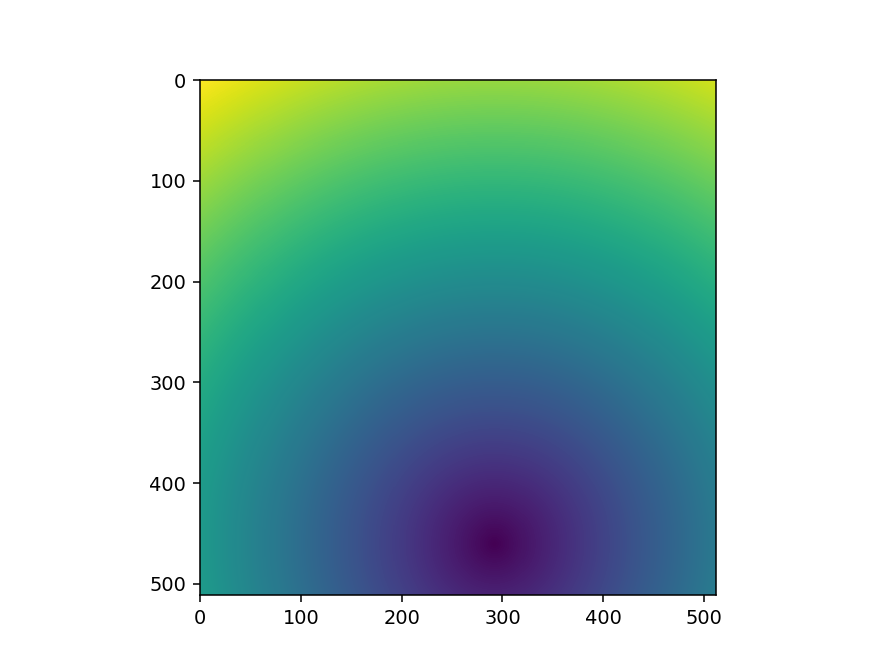

In [19]:
from matplotlib import pyplot
pyplot.figure()
problem = create_id22_17_problem()
pyplot.imshow(reduce_problem(problem, (512, 512)).image)
pyplot.show()

In [21]:
import timeit
import collections

TimeCollect = collections.namedtuple('TimeCollect', ['image_size',
                                                     'nb_polygons',
                                                     'nb_pixels',
                                                     'nb_points',
                                                     'problem_complexity',
                                                     'algorithm_name',
                                                     'precache_t', 'precache_dt',
                                                     'postprocess_t', 'postprocess_dt',
                                                     'compute_t', 'compute_dt'])

def get_t_dt(array):
    array = numpy.array(array)
    return array.mean(), array.max() - array.mean()


def collect_computation(collected_result, algorithm_name, algorithm_factory, problem):
    values = problem.values

    algo = algorithm_factory(problem.image, problem.mask)
    result = []
    scope = dict(globals())
    scope.update(locals())

    compute_time = timeit.repeat("[result.append(algo.iso_contour(v)) for v in values]", number=10, globals=scope)
    compute_time = get_t_dt(compute_time)
    nb_pixels = problem.image.shape[0] * problem.image.shape[1]
    nb_points, nb_polygons = 0, 0
    for r in result:
        nb_polygons += len(r)
        for p in r:
            nb_points += len(p)
    t = TimeCollect(algorithm_name=algorithm_name,
                    image_size=problem.image.shape,
                    problem_complexity=problem.complexity,
                    nb_pixels=nb_pixels,
                    nb_polygons=nb_polygons,
                    nb_points=nb_points,
                    precache_t=0,
                    precache_dt=0,
                    postprocess_t=0,
                    postprocess_dt=0,
                    compute_t=compute_time[0],
                    compute_dt=compute_time[1])
    collected_result.append(t)


problem_16mpx_17rings = create_id22_17_problem()
problem_4mpx_17rings = reduce_problem(problem_16mpx_17rings, (2096, 2096))
problem_1mpx_17rings = reduce_problem(problem_16mpx_17rings, (1024, 1024))
problem_250kpx_17rings = reduce_problem(problem_16mpx_17rings, (512, 512))

problems = [
    problem_16mpx_17rings,
    problem_4mpx_17rings,
    problem_1mpx_17rings,
    problem_250kpx_17rings]

algorithms = [
    # ("MarchingSquareCythonArray", lambda i, m: MarchingSquareCythonArray(i, m)),
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareSciKitImage", lambda i, m: MarchingSquareSciKitImage(i, m)),
    ("MarchingSquareCythonMap", lambda i, m: MarchingSquareCythonMap(i, m)),
    ("MarchingSquareCythonInsert", lambda i, m: MarchingSquareCythonInsert(i, m)),
    ("MarchingSquareCythonInsertOpenMp", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m)),
]

In [22]:
collected_result = []
for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (4096, 4096), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (2096, 2096), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (512, 512), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpenMp
[TimeCollect(image_size=(4096, 4096), nb_polygons=4860, nb_pixels=16777216, nb_points=1002690, problem_complexity=None, algorithm_name='Ma

In [12]:
problem_16mpx_17rings = create_id22_17_problem()
problems = [
    reduce_problem(problem_16mpx_17rings, (3000, 3000)),
    reduce_problem(problem_16mpx_17rings, (2500, 2500)),
    reduce_problem(problem_16mpx_17rings, (1500, 1500))]

for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (3000, 3000), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
Compute problem: image size = (2500, 2500), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
Compute problem: image size = (1500, 1500), iso contour count = 17
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
[TimeCollect(image_size=16777216, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=16.514224097666556, compute_dt=0.13068703333374287), TimeCollect(image_size=16777216, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=18.611873502666338, compute_dt=0.02009366333307483), TimeCollect(image_size=16777216, algorithm_na

In [23]:
import numpy
from matplotlib import pyplot
import pylab

def get_algorithms(collected_result):
    result = set([r.algorithm_name for r in collected_result])
    result = sorted(result)
    return result

def get_result_per_algorithm(collected_result, algorithm_name):
    result = [r for r in collected_result if r.algorithm_name == algorithm_name]
    result = sorted(result, key=lambda r: r.image_size)
    return result

In [24]:
styles = {
    "MarchingSquareCythonArray": {"linestyle": ":", "color": "green"},
    "MarchingSquareCythonArrayOpt": {"linestyle": "-", "color": "green"},
    "MarchingSquareSciKitImage": {"linestyle": "-", "color": "grey"},
    "MarchingSquareCythonMap": {"linestyle": "-", "color": "orange"},
    "MarchingSquareCythonInsert": {"linestyle": ":", "color": "red"},
    "MarchingSquareCythonInsertOpt": {"linestyle": "--", "color": "red"},
    "MarchingSquareCythonInsertOpenMp": {"linestyle": "-", "color": "red"},
}

def plot_computation(collected_result, by_complexity=False):
    algorithms = get_algorithms(collected_result)

    if by_complexity:
        xlegend = "x-axis: problem complexity"
    else:
        xlegend = "x-axis: number of pixels"

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        if by_complexity:
            x = numpy.array([r.problem_complexity for r in result]) + 1
        else:
            x = numpy.array([r.nb_pixels for r in result]) + 1
        compute_y = numpy.array([r.compute_t for r in result])
        compute_error = numpy.array([r.compute_dt for r in result])
        style = styles.get(algorithm, {})
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, label="%s" % (algorithm), **style)

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent (%s)" % xlegend)
    pyplot.legend
    pyplot.show()

def plot_computation_per_pixels(collected_result, by_complexity=False):
    algorithms = get_algorithms(collected_result)

    if by_complexity:
        xlegend = "x-axis: problem complexity"
    else:
        xlegend = "x-axis: number of pixels"

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        if by_complexity:
            x = numpy.array([r.problem_complexity for r in result]) + 1
        else:
            x = numpy.array([r.nb_pixels for r in result]) + 1
        nb_pixels = numpy.array([r.nb_pixels for r in result])
        compute_y = numpy.array([r.compute_t for r in result]) / nb_pixels * 1000000
        compute_error = numpy.array([r.compute_dt for r in result]) / nb_pixels * 1000000
        style = styles.get(algorithm, {})
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, label="%s" % (algorithm), **style)

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent per pixel (micro-second) (%s)" % xlegend)
    pyplot.legend
    pyplot.show()

def plot_computation_per_points(collected_result, by_complexity=False):
    algorithms = get_algorithms(collected_result)

    if by_complexity:
        xlegend = "x-axis: problem complexity"
    else:
        xlegend = "x-axis: number of pixels"

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        if by_complexity:
            x = numpy.array([r.problem_complexity for r in result]) + 1
        else:
            x = numpy.array([r.nb_pixels for r in result]) + 1
        nb_points = numpy.array([r.nb_points for r in result])
        compute_y = numpy.array([r.compute_t for r in result]) / nb_points * 1000000
        compute_error = numpy.array([r.compute_dt for r in result]) / nb_points * 1000000
        style = styles.get(algorithm, {})
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, label="%s" % (algorithm), **style)

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent per output points (micro-second)\n( (%s)" % xlegend)
    pyplot.legend
    pyplot.show()

<IPython.core.display.Javascript object>


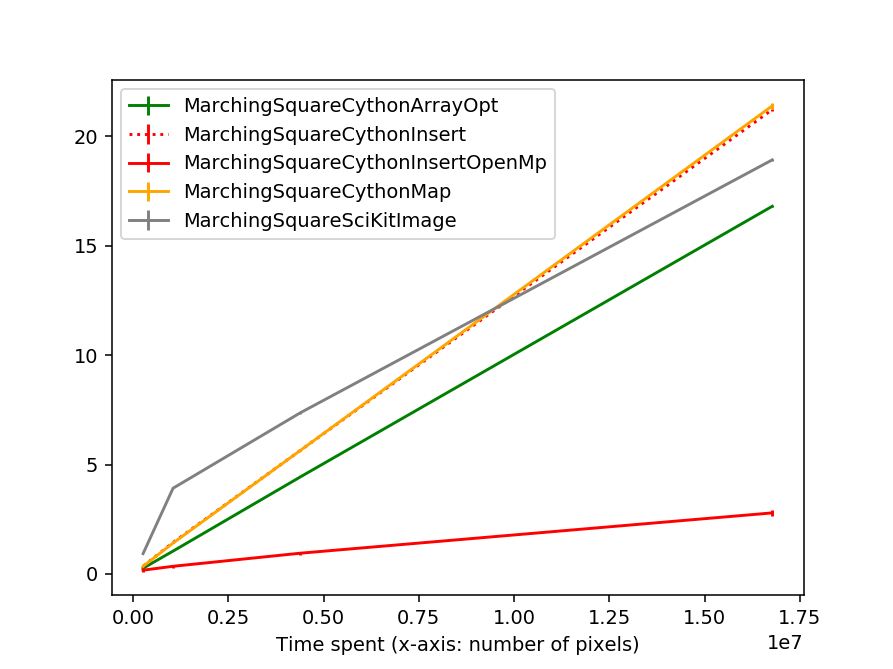

<IPython.core.display.Javascript object>


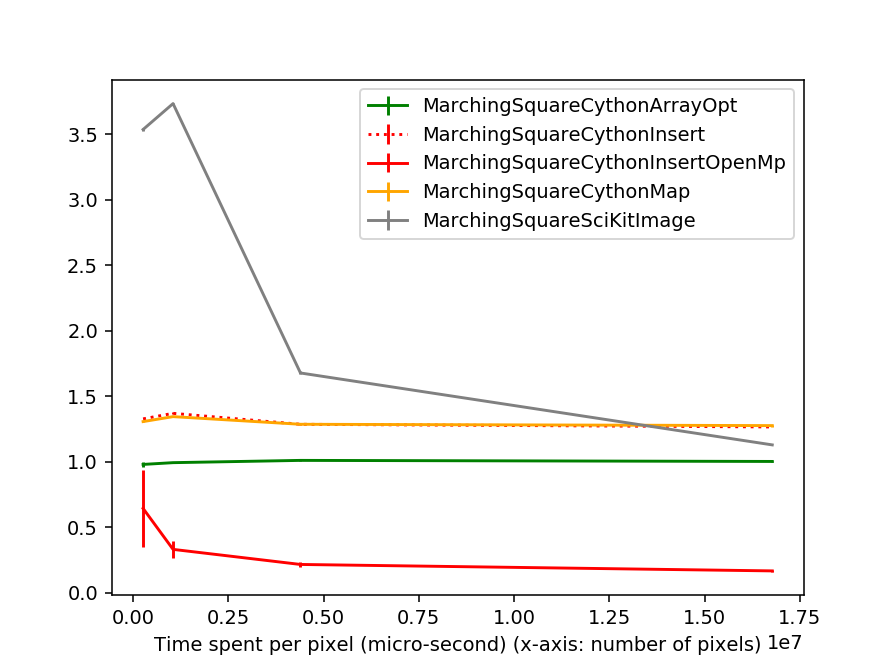

In [25]:
# Check computation time vs precache time
plot_computation(collected_result)
plot_computation_per_pixels(collected_result)

Benchmark on image size
=======================

Provide problems with different size to benchmark influence of the image size on the algorithms.

This problems are generated from an original downscaled image, to try to have the same iso contour complexity.

In [26]:
import skimage.transform

def scale_problem(problem, shape):
    result = Problem(
        image=skimage.transform.resize(problem.image, shape),
        mask=None,
        values=problem_16mpx_17rings.values,
        complexity=shape[0] * shape[1])
    return result

/home/valls/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


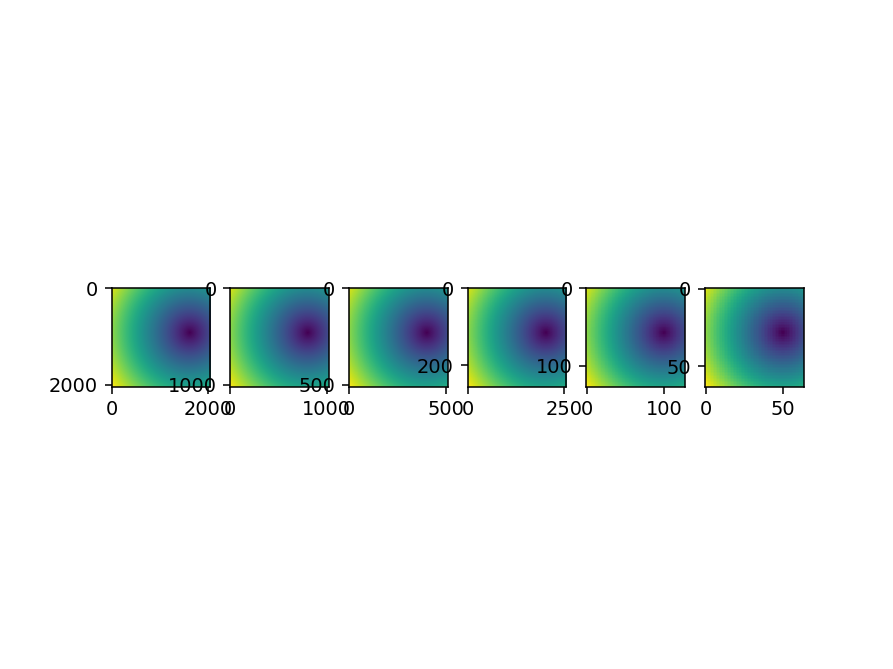

In [27]:
data = numpy.load(ROOT + "/data/id22_17.npz")
image = data["tth"]

problem_16mpx_17rings = create_id22_17_problem()

problem_1024 = Problem(
                    image=problem_16mpx_17rings.image[0:1024, image.shape[1] - 1024:],
                    mask=None,
                    values=problem_16mpx_17rings.values,
                    complexity=image.shape[0] * image.shape[1])

problems = [
    # scale_problem(problem_1024, (8192, 8192)),
    # scale_problem(problem_1024, (4096, 4096)),
    scale_problem(problem_1024, (2048, 2048)),
    scale_problem(problem_1024, (1024, 1024)),
    scale_problem(problem_1024, (512, 512)),
    scale_problem(problem_1024, (256, 256)),
    scale_problem(problem_1024, (128, 128)),
    scale_problem(problem_1024, (64, 64)),
]

pyplot.figure()
for i, p in enumerate(problems):
    pyplot.subplot(1, len(problems), i + 1)
    pyplot.imshow(p.image)
pyplot.show()

In [29]:
algorithms = [
    ("MarchingSquareCythonArray", lambda i, m: MarchingSquareCythonArray(i, m)),
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareSciKitImage", lambda i, m: MarchingSquareSciKitImage(i, m)),
    ("MarchingSquareCythonMap", lambda i, m: MarchingSquareCythonMap(i, m)),
    ("MarchingSquareCythonInsert", lambda i, m: MarchingSquareCythonInsert(i, m)),
    ("MarchingSquareCythonInsertOpt", lambda i, m: MarchingSquareCythonInsertOpt(i, m)),
    ("MarchingSquareCythonInsertOpenMp", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m)),
]

collected_result = []
for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (2048, 2048), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (512, 512), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (256, 256), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCython

<IPython.core.display.Javascript object>


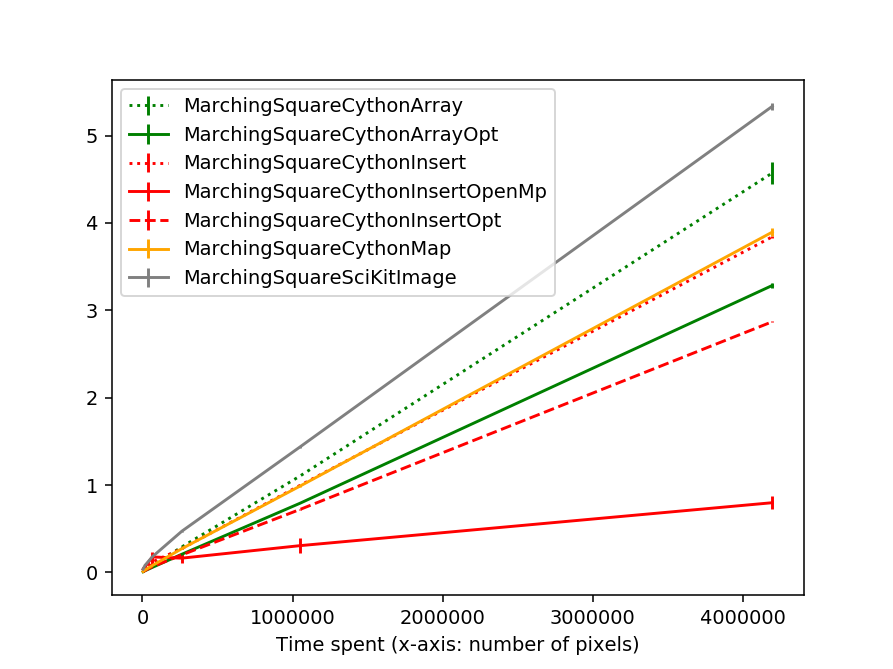

<IPython.core.display.Javascript object>


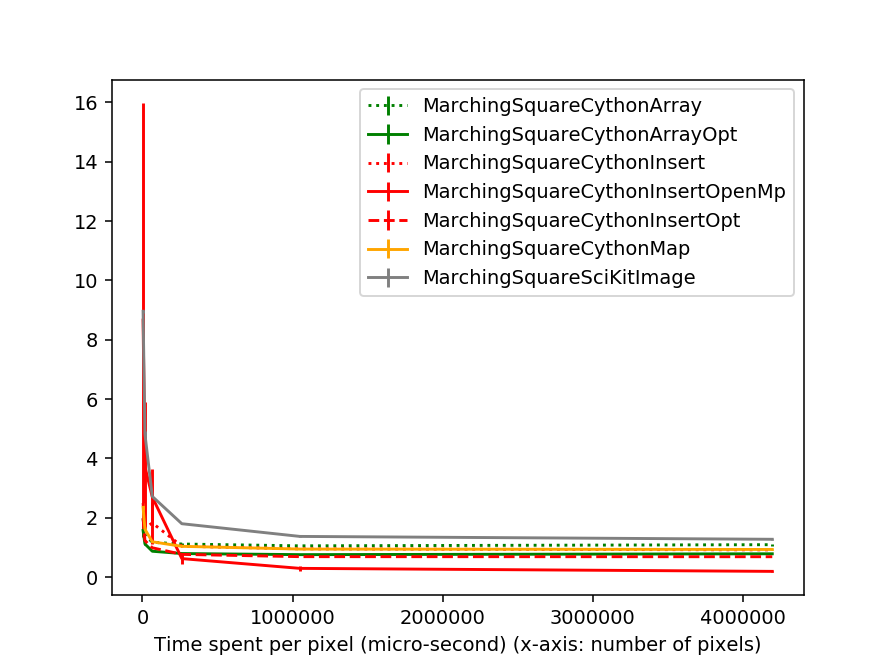

<IPython.core.display.Javascript object>


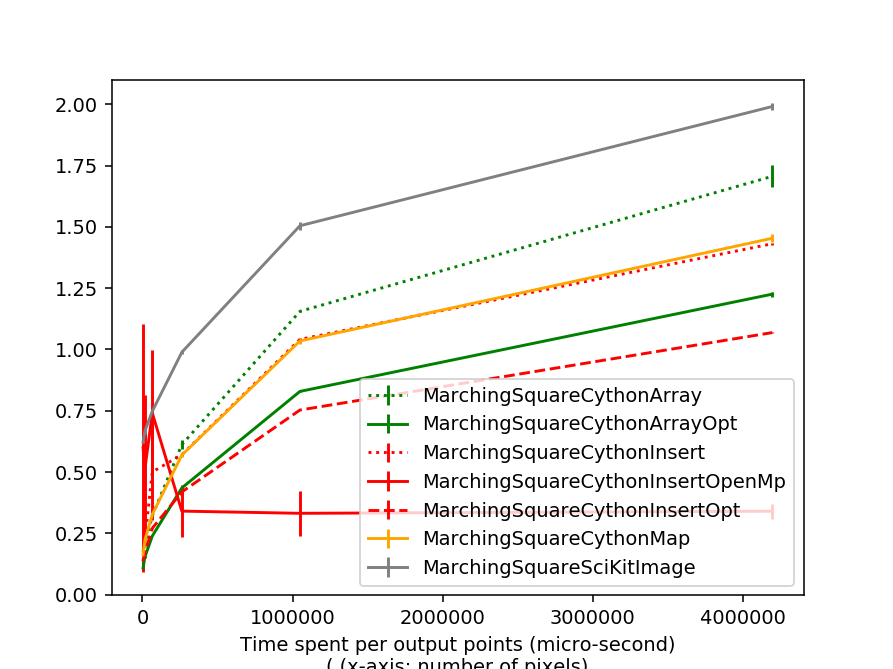

In [30]:
# Check computation time vs precache time
plot_computation(collected_result)
plot_computation_per_pixels(collected_result)
plot_computation_per_points(collected_result)

Benchmark of polygon complexity
===============================

Try to improve the polygon density the problems

In [31]:
import skimage.transform

def tiled_problem(problem, shape, count):
    """Create a zero array of the saze `shape`, containing `count` times
    the pattern `problem.image`."""
    tiled = numpy.zeros(shape, dtype=numpy.float32)
    pattern = problem.image
    available = numpy.array(tiled.shape) // numpy.array(pattern.shape)
    if count > available[0] * available[1]:
        raise RuntimeError("Not enougth space")
    i = 0
    for y in range(0, tiled.shape[0], pattern.shape[0]):
        if i >= count:
            break
        for x in range(0, tiled.shape[1], pattern.shape[1]):
            if i >= count:
                break
            tiled[y:y + pattern.shape[0], x:x + pattern.shape[1]] = pattern
            i += 1

    result = Problem(image=tiled,
                     mask=None,
                     values=problem.values,
                     complexity=count)
    return result

/home/valls/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


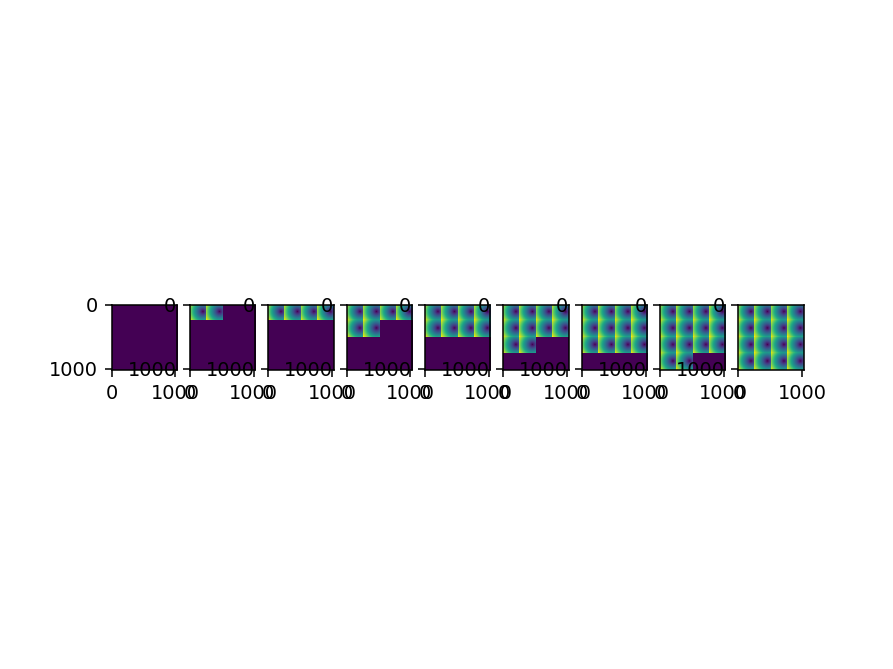

In [32]:
data = numpy.load(ROOT + "/data/id22_17.npz")
image = data["tth"]

problem_16mpx_17rings = create_id22_17_problem()

problem_1024 = Problem(image=problem_16mpx_17rings.image[0:1024, image.shape[1] - 1024:],
                       mask=None,
                       values=problem_16mpx_17rings.values,
                       complexity=None)
problem_256 = scale_problem(problem_1024, (256, 256))

problem_size = (1024, 1024)
problems = [
    tiled_problem(problem_256, problem_size, 0),
    tiled_problem(problem_256, problem_size, 2),
    tiled_problem(problem_256, problem_size, 4),
    tiled_problem(problem_256, problem_size, 6),
    tiled_problem(problem_256, problem_size, 8),
    tiled_problem(problem_256, problem_size, 10),
    tiled_problem(problem_256, problem_size, 12),
    tiled_problem(problem_256, problem_size, 14),
    tiled_problem(problem_256, problem_size, 16),
]

pyplot.figure()
for i, p in enumerate(problems):
    pyplot.subplot(1, len(problems), i + 1)
    pyplot.imshow(p.image)
pyplot.show()

In [33]:
algorithms = [
    ("MarchingSquareCythonArray", lambda i, m: MarchingSquareCythonArray(i, m)),
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareSciKitImage", lambda i, m: MarchingSquareSciKitImage(i, m)),
    ("MarchingSquareCythonMap", lambda i, m: MarchingSquareCythonMap(i, m)),
    ("MarchingSquareCythonInsert", lambda i, m: MarchingSquareCythonInsert(i, m)),
    ("MarchingSquareCythonInsertOpt", lambda i, m: MarchingSquareCythonInsertOpt(i, m)),
    ("MarchingSquareCythonInsertOpenMp", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m)),
]

collected_result = []
for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCy

<IPython.core.display.Javascript object>


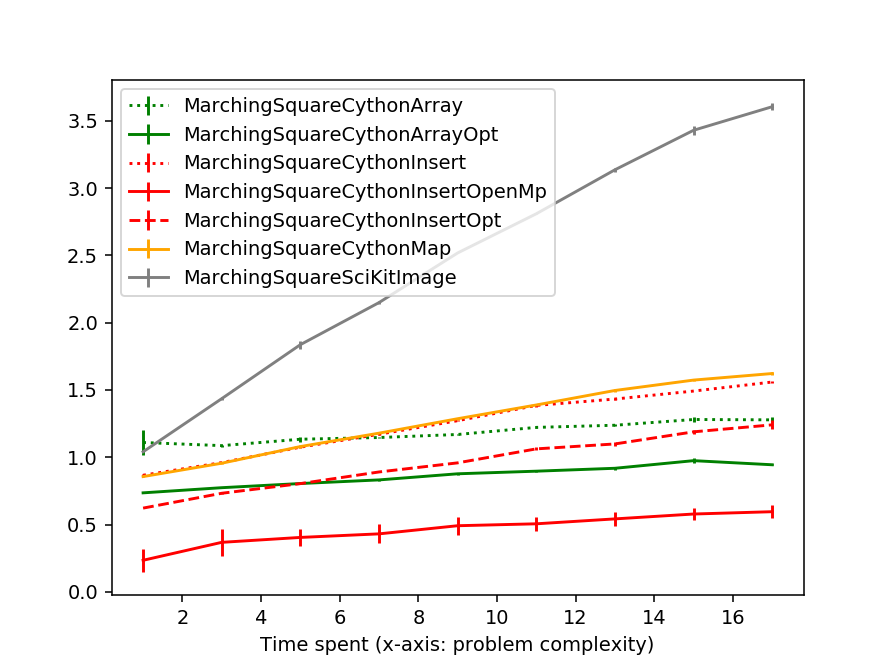

<IPython.core.display.Javascript object>


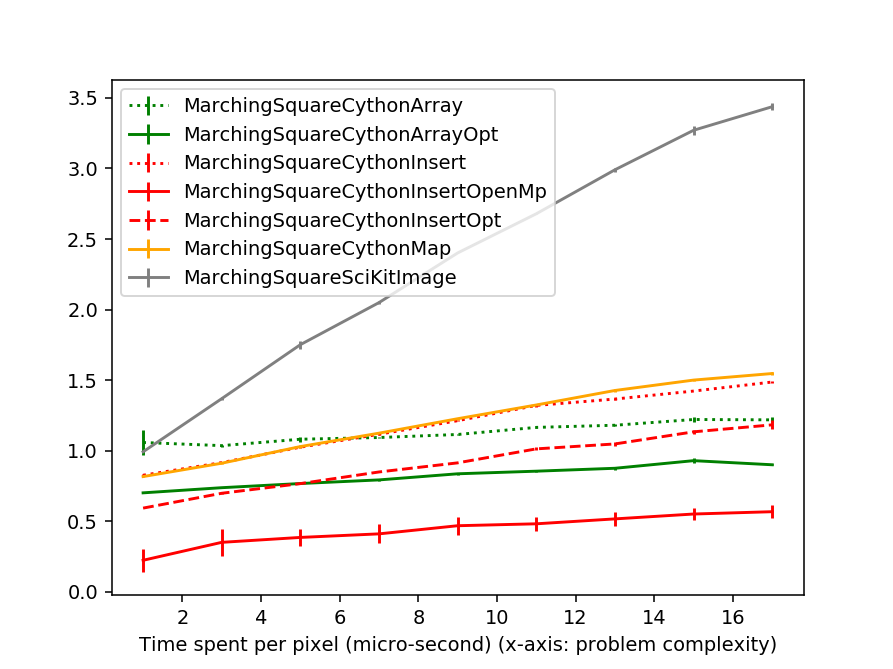

<IPython.core.display.Javascript object>


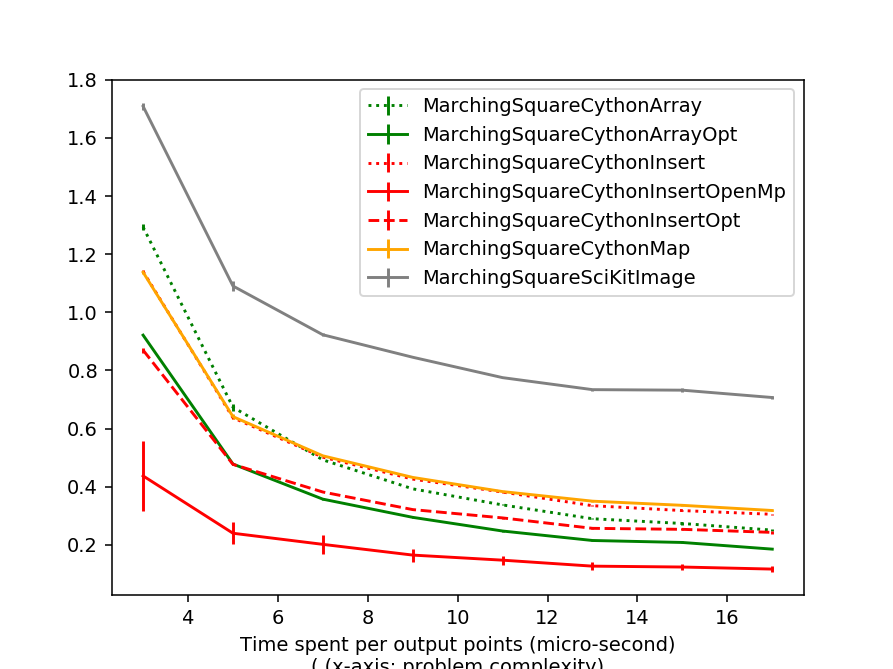

/home/valls/.local/lib/python3.5/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/valls/.local/lib/python3.5/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/valls/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


In [34]:
# Check computation time vs precache time
plot_computation(collected_result, by_complexity=True)
plot_computation_per_pixels(collected_result, by_complexity=True)
plot_computation_per_points(collected_result, by_complexity=True)

Benchmark pathological problem
==============================

Create a problem with a pattern with require to gererate a polygon point for each pixels of the image.

This should penelize algorithms which preprocess the image and read it again to create polygons.

<IPython.core.display.Javascript object>


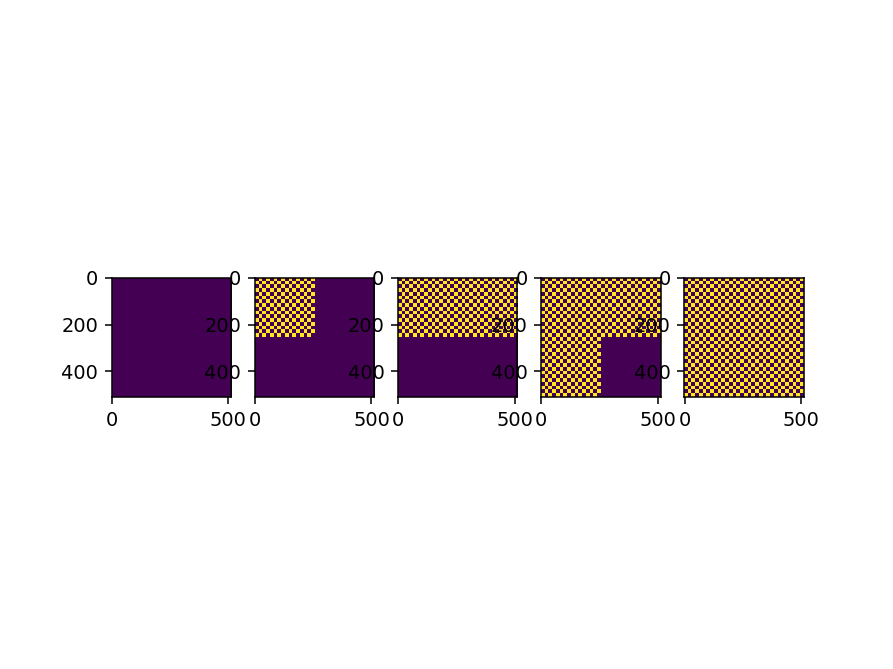

In [35]:
image = numpy.zeros((256, 256),dtype=int)
image[1::2,::2] = 1
image[::2,1::2] = 1

problem_256 = Problem(image=image,
                      mask=None,
                      values=[0.5],
                      complexity=None)

problem_size = (512, 512)
problems = [
    tiled_problem(problem_256, problem_size, 0),
    tiled_problem(problem_256, problem_size, 1),
    tiled_problem(problem_256, problem_size, 2),
    tiled_problem(problem_256, problem_size, 3),
    tiled_problem(problem_256, problem_size, 4),
]

pyplot.figure()
for i, p in enumerate(problems):
    pyplot.subplot(1, len(problems), i + 1)
    pyplot.imshow(p.image)
pyplot.show()

In [36]:
algorithms = [
    ("MarchingSquareCythonArray", lambda i, m: MarchingSquareCythonArray(i, m)),
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareSciKitImage", lambda i, m: MarchingSquareSciKitImage(i, m)),
    ("MarchingSquareCythonMap", lambda i, m: MarchingSquareCythonMap(i, m)),
    ("MarchingSquareCythonInsert", lambda i, m: MarchingSquareCythonInsert(i, m)),
    ("MarchingSquareCythonInsertOpt", lambda i, m: MarchingSquareCythonInsertOpt(i, m)),
    ("MarchingSquareCythonInsertOpenMp", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m)),
]

collected_result = []
for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (512, 512), iso contour count = 1
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (512, 512), iso contour count = 1
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (512, 512), iso contour count = 1
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- MarchingSquareCythonInsert
- MarchingSquareCythonInsertOpt
- MarchingSquareCythonInsertOpenMp
Compute problem: image size = (512, 512), iso contour count = 1
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonMap
- Ma

<IPython.core.display.Javascript object>


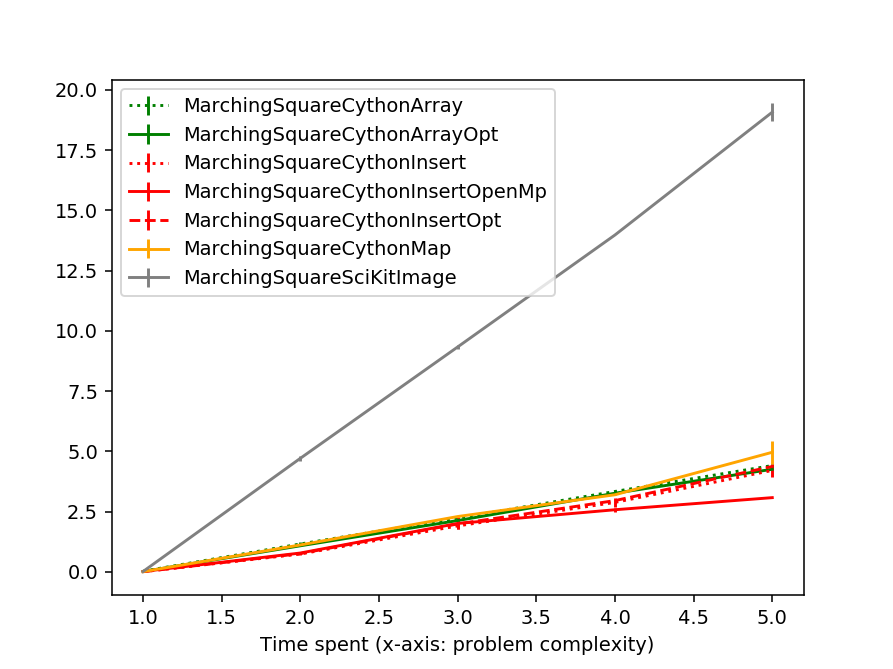

<IPython.core.display.Javascript object>


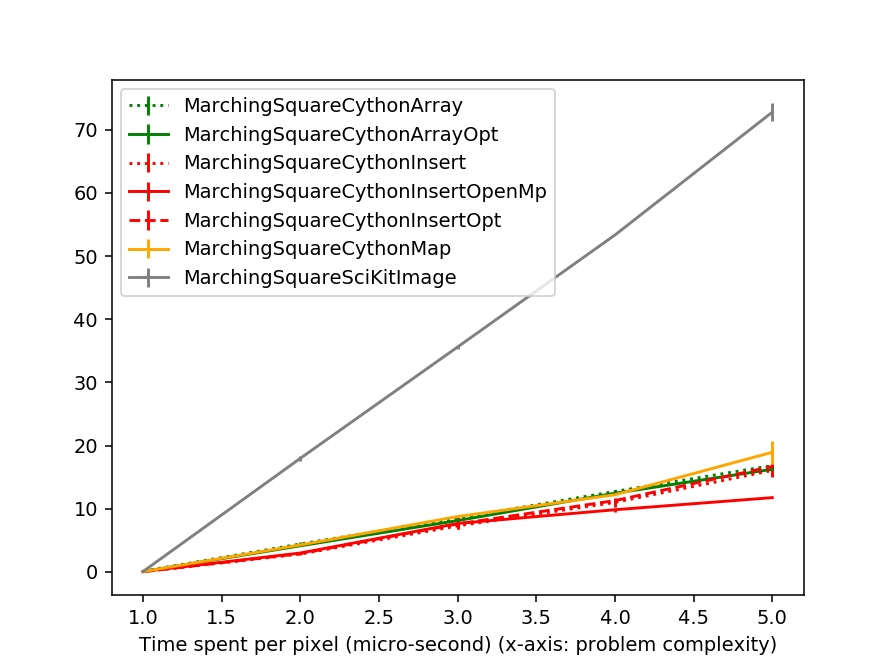

<IPython.core.display.Javascript object>


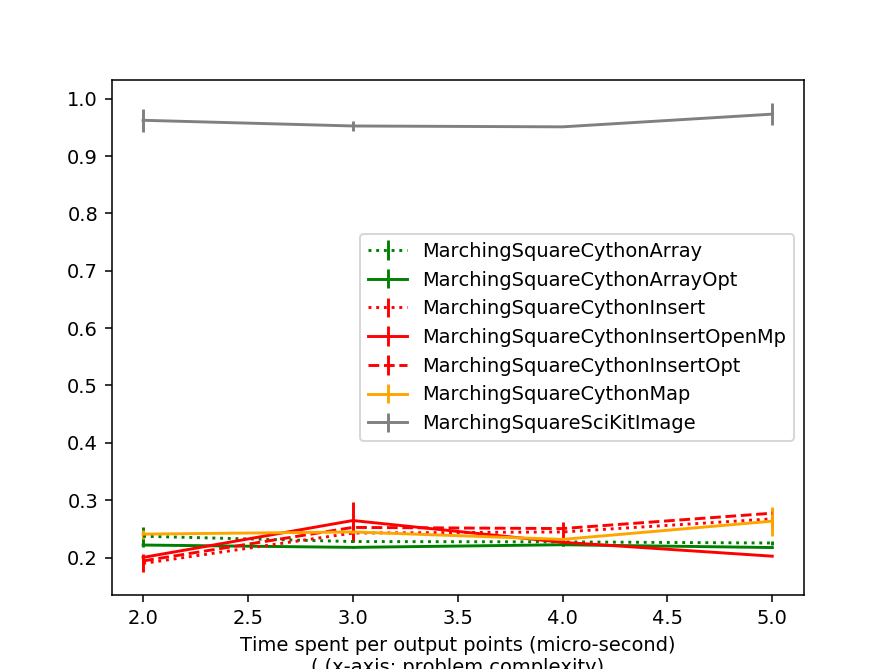

/home/valls/.local/lib/python3.5/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/valls/.local/lib/python3.5/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/valls/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


In [37]:
# Check computation time vs precache time
plot_computation(collected_result, by_complexity=True)
plot_computation_per_pixels(collected_result, by_complexity=True)
plot_computation_per_points(collected_result, by_complexity=True)